# TP: Measuring raw camera calibration accuracy

### Name: **[Imane SI SALAH]**

The objective of this TP is to perform a simple camera calibration, and measuring its accuracy.

We will go through the following steps:
- Import a raw image containing a ColorChecker chart
- Extract values from color patches in "linear raw RGB" device colorspace
- Find reference color patch values in CIE-XYZ colorspace
- Find a linear 3x3 color calibration matrix
- Perform color rendering and gamma compression
- Assess the quality of the calibration
- Compare the raw image to the JPEG image produced by the same sensor

The purpose of the TP is to introduce the basic concept of calibration to reach the fidelity of color rendering and to assess it using a perceptually uniform color space.

Answer the questions below and then export the notebook with the answers using the menu option File->Download .ipynb. **[Then submit your solution here!](https://docs.google.com/forms/d/e/1FAIpQLSf1RKdUeP3fFogaQ2TqDfSO8fQnxG8dFI-wh7c-ywuLj7BYkA/viewform)**

Install necessary modules:

In [1]:
!pip install colour-science rawpy opencv-python

Import necessary modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import colour
import cv2

In [3]:
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install -q hdf5storage

    !rm -fr IspPipeline
    !git clone -b main --single-branch --quiet https://github.com/DXOMARK-OCTO/IspPipeline
    !cp -r IspPipeline/* .

except ImportError:
    # %matplotlib notebook
    pass

%matplotlib inline

import fastisp

# Helper function for displaying images
def imshow(im, **kwargs):
  im = im / im.max()
  plt.figure(figsize=(8, 8))
  plt.imshow(im, **kwargs)
  plt.axis('off')
  plt.show()

# Import a Raw Image

In this section we will import a raw image from a DNG file.
DNG is a universal file format developped by Adobe for raw images.
It contains the raw data from the sensor as well as some metadata useful to transform the raw data to a viewable image.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
filename = "Gretag_6500K_100Lux"
raw = rawpy.imread(rf"./OppoFindX3Pro/ColorChecker/{filename}.dng")

In [6]:
print(raw)

Now let's extract the raw data:

In [7]:
print(raw.raw_image.shape)

(3072, 4096)


In [8]:
imageB = raw.raw_image[::2, ::2]
imageG2 = raw.raw_image[::2, 1::2]
imageR = raw.raw_image[1::2, 1::2]
imageG1 = raw.raw_image[1::2, ::2]

In [9]:
print(imageB.shape)

(1536, 2048)


Let's explore some of the metadata.

In [10]:
bayer_pattern = raw.raw_pattern
print(f"Bayer pattern: {bayer_pattern}")
blc = raw.black_level_per_channel
print(f"Black level: {blc}")
wl  = raw.white_level
print(f"White level: {wl}")

Bayer pattern: [[2 3]
 [1 0]]
Black level: [64, 64, 64, 64]
White level: 1023


In [11]:
# THE RAW IMAGE ISA T 10bits

Let's display these channels:

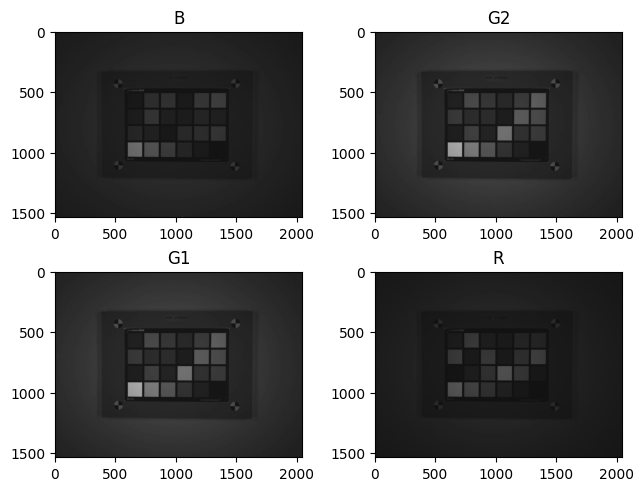

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
axes[0, 0].imshow(imageB, vmin=0, vmax=1024, cmap="gray")
axes[0, 0].set_title("B")
axes[0, 1].imshow(imageG2, vmin=0, vmax=1024, cmap="gray")
axes[0, 1].set_title("G2")
axes[1, 1].imshow(imageR, vmin=0, vmax=1024, cmap="gray")
axes[1, 1].set_title("R")
axes[1, 0].imshow(imageG1, vmin=0, vmax=1024, cmap="gray")
axes[1, 0].set_title("G1")
fig.show()

# Measuring raw sensor RGB response

First, let's find patch ROIs on the ColorChecker:

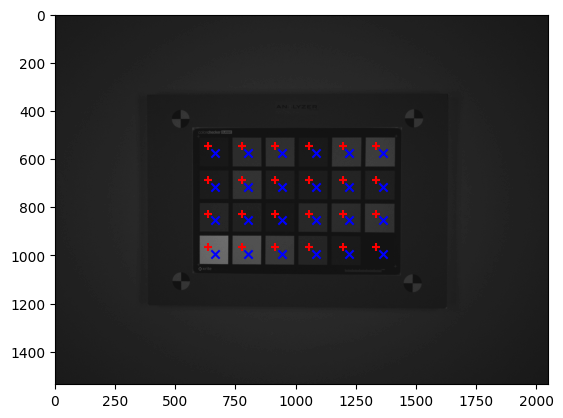

In [13]:
coordinates = ((x0, y0), (x1, y1)) = np.array([
    [580, 490],
    [1420, 1050],
])

rectangles = np.round(np.array([
    [
        [x0 + (0.4+i)/6*(x1-x0), y0 + (0.4+j)/4*(y1-y0)],
        [x0 + (0.6+i)/6*(x1-x0), y0 + (0.6+j)/4*(y1-y0)]
    ] for j in range(4) for i in range(6)
])).astype(int)

plt.imshow(imageB, vmin=0, vmax=1024, cmap="gray")
plt.scatter(*rectangles[:, 0, :].T, marker="+", color="red")
plt.scatter(*rectangles[:, 1, :].T, marker="x", color="blue")
plt.show()

Extract average RGB values from these patches. These RGB values are in an arbitrary "raw RGB" colorspace, which is specific to the camera (sensor and lens included).

In [14]:
patchesR = [np.mean(imageR[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(imageG1[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(imageB[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T

In [15]:
print(patches.shape)

(24, 3)


We can show RGB raw values for the gray patches:

In [16]:
patches[18:, :]

array([[ 320.88647959,  638.99362245,  416.77423469],
       [ 251.09311224,  474.27040816,  319.49362245],
       [ 188.38137755,  331.77423469,  230.78316327],
       [ 127.54464286,  200.44770408,  148.99489796],
       [  93.4744898 ,  128.80994898,  104.88265306],
       [  73.93367347,   86.40816327,   78.18494898]])

Note that while this space is called "linear", it is in fact an affine transformation of the amount of light in the scene, since it includes the black level offset from the camera.

We can convert these to "sensor linear RGB" colorspace:

In [17]:
raw_linear_rgb = patches - raw.black_level_per_channel[0] # romove the noise for black level
raw_linear_rgb[18:, :]

array([[ 256.88647959,  574.99362245,  352.77423469],
       [ 187.09311224,  410.27040816,  255.49362245],
       [ 124.38137755,  267.77423469,  166.78316327],
       [  63.54464286,  136.44770408,   84.99489796],
       [  29.4744898 ,   64.80994898,   40.88265306],
       [   9.93367347,   22.40816327,   14.18494898]])

# Measuring the Noise response of the sensor

Let's plot the SNR for one green channel of the gray patches, as a function of the grey level in percentage.

In [18]:
stdR = [np.std(imageR[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
stdG = [np.std(imageG1[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
stdB = [np.std(imageB[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
stds = np.vstack((stdR, stdG, stdB)).T

SNR = ( np.array(patchesG[18:]) - blc[0] )/np.array(stdG[18:])
GrayLevels = ( np.array(patchesG[18:]) - blc[0] )/(wl - blc[0])

In [19]:
print(SNR)
print(GrayLevels)

[ 33.95567054  28.80958068  22.91646372  16.90372538  12.28923441
   6.53593139]
[ 0.59957625  0.42781064  0.27922235  0.14228123  0.06758076  0.02336618]


In [20]:
print(20*np.log10(SNR))
print(np.log2(GrayLevels))

[ 30.61824622  29.19073874  27.20295204  24.55964857  21.79049657
  16.30614969]
[-0.73798486 -1.22495572 -1.84051366 -2.8131827  -3.88724361 -5.41943451]


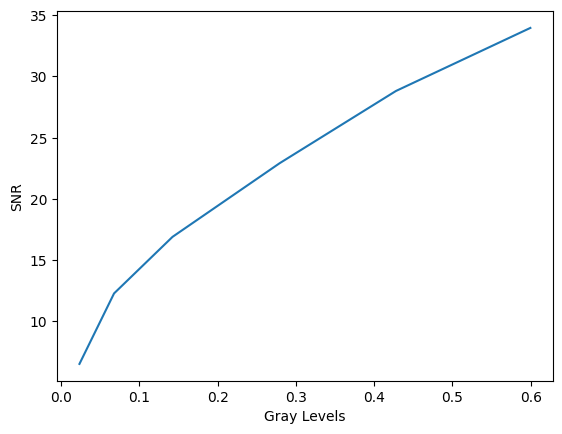

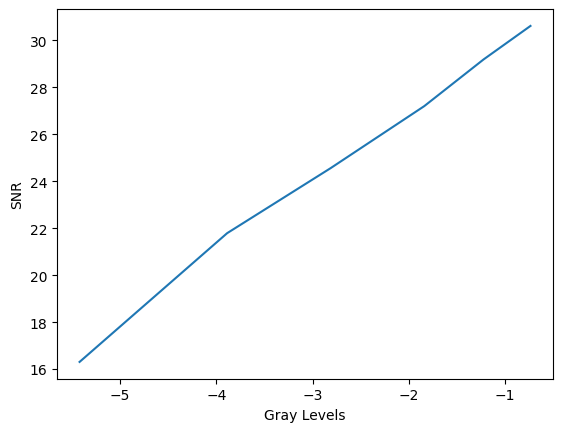

In [21]:
fig = plt.figure()
plt.plot(GrayLevels,SNR)
plt.ylabel('SNR')
plt.xlabel('Gray Levels')
plt.show()

fig = plt.figure()
plt.plot(np.log2(GrayLevels),20*np.log10(SNR))
plt.ylabel('SNR')
plt.xlabel('Gray Levels')
plt.show()

It seems that we have a slope of around 3dB per stop around gray levels of 2e-3 (at stop -3) whichis 0.125
Can you estimate the full well capacity in photons with the following hypothesis?

We make the following assumption:
- photon to electron conversion is 100% efficient.
- the sensor is linear
- noise regime is purely photonic at this grey level (RAW data) of 10%


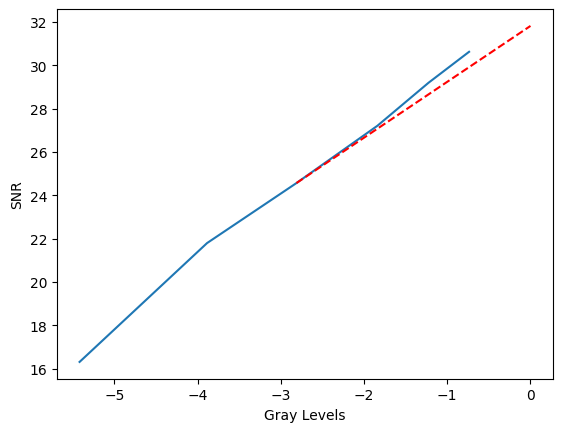

In [22]:
#extend the line at the -3dB sole

# Define the slope and starting point
slope = (- 24.55964857 + 21.79049657)/(2.8131827 - 3.88724361)
start_point = (-2.8131827, 24.55964857 )

# Generate x values
x = np.linspace(-2.8131827, 0, 100)  # Adjust the range as needed

# Calculate the corresponding y values
y = start_point[1] + slope * (x - start_point[0])

# Plot the line
fig = plt.figure()
plt.plot(np.log2(GrayLevels),20*np.log10(SNR))
plt.plot(x, y, color='r', linestyle='dashed')
plt.ylabel('SNR')
plt.xlabel('Gray Levels')
plt.show()



In [23]:
#the crossing point is

print('the crossing point is at SNR=',y[-1], 'dB')

print('therefore the FWC= (SNR)**2= ', (y[-1])**2)

the crossing point is at SNR= 31.8126175846 dB
therefore the FWC= (SNR)**2=  1012.04263759


# Find reference patch data

The [Color Checker](https://en.wikipedia.org/wiki/ColorChecker) is a widely used chart in image science. It contains patches of reference color that are well documented.

The [colour-science](https://www.colour-science.org/) library contains reference values in xyY coordinates from various sources, under the D50 illuminant.


In [24]:
colour.CCS_COLOURCHECKERS["BabelColor Average"].data

{'dark skin': array([ 0.4325,  0.3788,  0.1034]),
 'light skin': array([ 0.4191,  0.3748,  0.3525]),
 'blue sky': array([ 0.2761,  0.3004,  0.1847]),
 'foliage': array([ 0.37  ,  0.4501,  0.1335]),
 'blue flower': array([ 0.302 ,  0.2877,  0.2324]),
 'bluish green': array([ 0.2856,  0.391 ,  0.4174]),
 'orange': array([ 0.5291,  0.4075,  0.3117]),
 'purplish blue': array([ 0.2339,  0.2155,  0.114 ]),
 'moderate red': array([ 0.5008,  0.3293,  0.1979]),
 'purple': array([ 0.3326,  0.2556,  0.0644]),
 'yellow green': array([ 0.3989,  0.4998,  0.4435]),
 'orange yellow': array([ 0.4962,  0.4428,  0.4358]),
 'blue': array([ 0.204 ,  0.1696,  0.0579]),
 'green': array([ 0.327 ,  0.5033,  0.2307]),
 'red': array([ 0.5709,  0.3298,  0.1268]),
 'yellow': array([ 0.4694,  0.4732,  0.6081]),
 'magenta': array([ 0.4177,  0.2704,  0.2007]),
 'cyan': array([ 0.2151,  0.3037,  0.1903]),
 'white 9.5 (.05 D)': array([ 0.3488,  0.3628,  0.9129]),
 'neutral 8 (.23 D)': array([ 0.3451,  0.3596,  0.5885])

We actually need the reference values under another illuminant: [D65](https://en.wikipedia.org/wiki/Illuminant_D65) in order to display the resulting image, since the standard sRGB display uses that illuminant.

There are different ways to find an estimate of a XYZ color under an illuminant given the XYZ color coordinates under another illuminant, called "chromatic adaptation" models.

The [Bradford adaptation](http://www.brucelindbloom.com/index.html?Eqn_ChromAdapt.html) is one of the chromatic adaptation models that we propose to use here.

#####


In [25]:
cc_xyY_d50 = np.array([v for v in colour.CCS_COLOURCHECKERS["BabelColor Average"].data.values()])
XYZ_wr_d65 = colour.xy_to_XYZ(colour.CCS_ILLUMINANTS["cie_2_1931"]["D65"])
XYZ_w_d50 = colour.xy_to_XYZ(colour.CCS_ILLUMINANTS["cie_2_1931"]["D50"])
m_d50_to_d65 = colour.adaptation.matrix_chromatic_adaptation_VonKries(XYZ_w_d50, XYZ_wr_d65, "Bradford")
cc_XYZ_d65 = (m_d50_to_d65 @ colour.xyY_to_XYZ(cc_xyY_d50).T).T

print(cc_XYZ_d65)

[[ 0.11367164  0.10216807  0.067859  ]
 [ 0.38073324  0.34891967  0.25549944]
 [ 0.17440606  0.18720906  0.34471351]
 [ 0.1051476   0.13284377  0.0695999 ]
 [ 0.24868724  0.23477596  0.43916727]
 [ 0.30350611  0.42018688  0.45448426]
 [ 0.38256031  0.30435439  0.06310772]
 [ 0.13401642  0.1177579   0.38667971]
 [ 0.28945355  0.19348819  0.13548479]
 [ 0.08514523  0.06484947  0.13774409]
 [ 0.33364715  0.43978245  0.11484894]
 [ 0.46034252  0.42756472  0.07694581]
 [ 0.0787333   0.06100262  0.28416582]
 [ 0.14280639  0.23039038  0.10059871]
 [ 0.20920983  0.12264368  0.05089378]
 [ 0.56697758  0.59861721  0.09308991]
 [ 0.30623523  0.19878174  0.30768514]
 [ 0.14345981  0.19472284  0.39889227]
 [ 0.86341261  0.91239506  0.95751959]
 [ 0.55660076  0.58852863  0.63781236]
 [ 0.34018697  0.3595489   0.39174647]
 [ 0.18060313  0.19124766  0.20904204]
 [ 0.0843512   0.08934444  0.09892032]
 [ 0.03045657  0.03200997  0.03550083]]


# Find the calibration matrix

Thanks to this XYZ D65 references, we will find the best matrix that transform the raw data (proportionnal to luminance in the scene) to XYZ, through least mean square minimization.

In [26]:
# Build a linear system
A = []
b = []

for measured_linear_rgb, reference_xyz in zip(raw_linear_rgb, cc_XYZ_d65):
  A.append(measured_linear_rgb.tolist() + [0, 0, 0, 0, 0, 0])
  A.append([0, 0, 0] + measured_linear_rgb.tolist() + [0, 0, 0])
  A.append([0, 0, 0, 0, 0, 0] + measured_linear_rgb.tolist())
  b.extend(reference_xyz)
A = np.array(A) #I get a of size (72,3)
b = np.array(b) #I get a of size (72,)

# ... and solve it!
x, resid, _, _ = np.linalg.lstsq(A, b, rcond=None) #solves the system( A @ x= b)
x = x.reshape((3, 3))

print(f"Residual:{resid}")
print(f"Calibration Matrix:\n{x}")


Residual:[ 0.04548586]
Calibration Matrix:
[[ 0.00160534  0.00047231  0.00028317]
 [ 0.0003649   0.00148986 -0.00030463]
 [-0.00012307 -0.00055902  0.00354769]]


The [colour-science](https://www.colour-science.org/) library provides useful tools to visualize color patches! Let's look at the results.

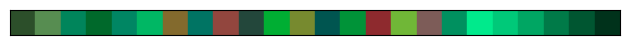

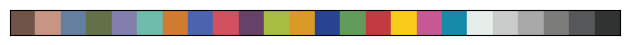

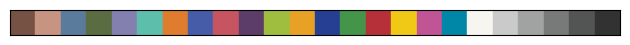

In [27]:
rgb = colour.XYZ_to_sRGB((raw_linear_rgb.T).T/1023) #dispaly just for the raw image (codes in 10 bit so need to normalize)
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

rgb = colour.XYZ_to_sRGB((x @ raw_linear_rgb.T).T)#apply the matrix that we just found  to the raw image
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

rgb = colour.XYZ_to_sRGB(cc_XYZ_d65) # dislay the reference
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

# Applying Calibration

Let's apply the calibration matrix to the image, and observe the results.

In [28]:
print(imageR)

[[97 90 93 ..., 87 82 90]
 [96 84 95 ..., 85 87 90]
 [94 93 93 ..., 82 88 87]
 ..., 
 [96 92 81 ..., 87 88 94]
 [92 84 90 ..., 94 85 89]
 [98 92 95 ..., 91 88 90]]


the shape o fraw image (1536, 2048, 3)
the resulting image shape is (1536, 2048, 3)


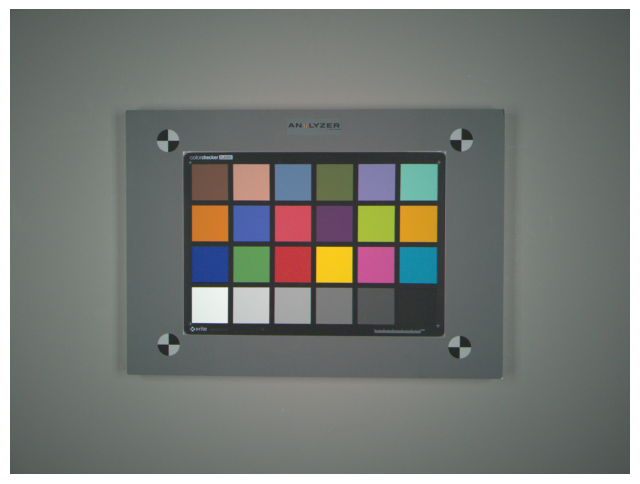

In [29]:
img_raw = np.dstack([imageR, imageG1, imageB]).astype(np.float32) - raw.black_level_per_channel[0] #rebuild the 3 channels
print('the shape o fraw image', ((x @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)).shape)
img_rgb = np.clip(colour.XYZ_to_sRGB((x @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1) #apply calibration here vectorize image row then reshape it again
print('the resulting image shape is',img_rgb.shape)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
cv2.imwrite("img_rgb.jpg",img_bgr)

imshow(img_rgb)
plt.show()

toutes les coulerus n'ont pas forcement la meme impoortancae
il y des couleru sur  les quelle sle cerveau hulain a des apprioris (ciel est bleu..):
la perception de couleur depend du contexte, cette grille n'est pas suffisant epour estimer la couleur

### <font color='blue'>Question:</font>

<ul>

<li><font color='blue'>Can you explain what does the above code?</font></li>

<li><font color='blue'>Can you make the link to the previous processing pipeline that we presented during the last TP?</font></li>

<li><font color='blue'>Where are hidden the demosaicing, white balance, color rendering and gamma steps?</font></li>

</ul>

<font color='red'> Answer here</font>
<ul >
<li><font color='red'>  In the  code above, first the 3 raw channels are stacked together to build the raw rgb image with 3 channels, then the calibration matrix x that was computed using mean square minimization to recover the refence color values is applied to this raw image. The resulting image is converted from linear space to the sRGB color space. after that it is converted to BGR format because it is the image format suported by openCV and saved. finally it was displayed </font></li>

<li><font color='red'>  the color calibration step coincides with white balance , demosicing and gamma correction of the previous pipline, since it retreived the colored image from the raw image.</font></li>

<li><font color='red'> I think all these processes depend on the calibration matrix that depends on the reference values whe have used. since the white balance depends strongly on the illuminant then in this process it is somehow hidden on the choice of the refence illuminant (in this case D65). as for the demosicing it was done directly by taking imageB, imageG1 and imageR from the raw image note that the size of these channels is much smaller than the raw image.</font></li>
</ul>




# Comparing to the JPEG generated by the camera

Let's observe the JPEG files provided by the camera.

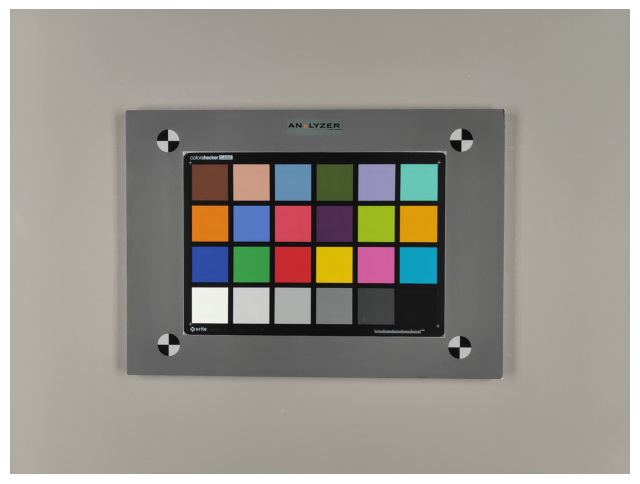

In [30]:
path = r"/content/OppoFindX3Pro/ColorChecker/Gretag_6500K_100lux.jpg"
img_jpg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[::2, ::2, :]
imshow(img_jpg)

<font color='red'> this is different from the claibrated image we got before, colors are more saturated</font>

# Measure the differences between our calibration and the camera JPEG images

We will use the [CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space) color space to quantify the differences between the images.

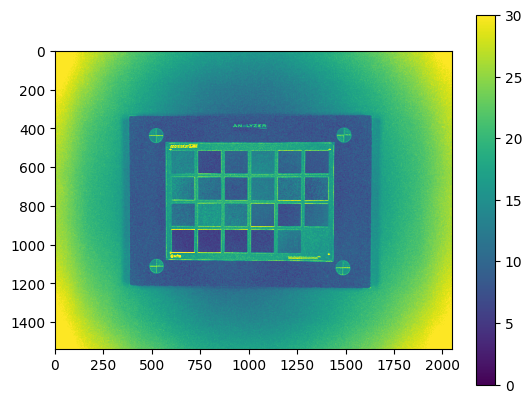

In [31]:
deltalab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_jpg / 255.0)) - colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_rgb)) #sRGB to XYZ then from this to LAB again because we can go from any space toXYZ and vice versa
deltae = np.linalg.norm(deltalab, axis=-1)
plt.imshow(deltae, vmin=0, vmax=30)
plt.colorbar()
plt.show()

In [32]:
patchesR = [np.mean(img_jpg[py0:py1, px0:px1,0]/255) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(img_jpg[py0:py1, px0:px1,1]/255) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(img_jpg[py0:py1, px0:px1,2]/255) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T
lab_jpg = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches))

patchesR = [np.mean(img_rgb[py0:py1, px0:px1,0]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(img_rgb[py0:py1, px0:px1,1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(img_rgb[py0:py1, px0:px1,2]) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T
lab_rgb = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches))

deltae_rgb = np.linalg.norm(lab_jpg - lab_rgb, axis=-1)
print(deltae_rgb)

[ 11.53478746   3.20889543   6.67561198  10.56731865   8.15732823
   5.83506993  10.50611566   9.1771648    4.02512592   9.23329067
   8.82152624   5.94590168   6.97358328  15.08116162   9.66906652
   8.38707276   3.74166428   8.47525612   2.53364277   1.55976285
   2.68578261   1.21425904   8.36922133  12.64489251]


In [33]:
#deltae seuil pour distinguer les differences de coulers on veut optimizer le deltae pour que la difference soit la moins perceptible possible

# Comparing to our pipeline of TP1



In [34]:
cm = raw.color_matrix[0:3,0:3]
print(f"Color Matrix: {cm}")
wb = np.array(raw.camera_whitebalance)
print(f"White Balance: {wb}")

img_isp = fastisp.isp(raw.raw_image, bayer_pattern, blc[0], 1.8, wb[:3], cm, wl) #1.8  is gamma???
ims_isp = img_isp[::2, ::2, :]

patchesR = [np.mean(ims_isp[py0:py1, px0:px1,0]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(ims_isp[py0:py1, px0:px1,1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(ims_isp[py0:py1, px0:px1,2]) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T
lab_isp = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches))

Color Matrix: [[ 1.7879809  -0.80493003  0.01694908]
 [-0.1830969   1.2751694  -0.09207252]
 [-0.0547976  -0.6531928   1.7079904 ]]
White Balance: [ 1.98449612  1.          1.59006214  0.        ]


In [35]:
print(patches[21])
print(lab_isp[21])

[ 0.50426805  0.54216305  0.53375786]
[ 56.7473914   -3.95423627  -0.06666053]


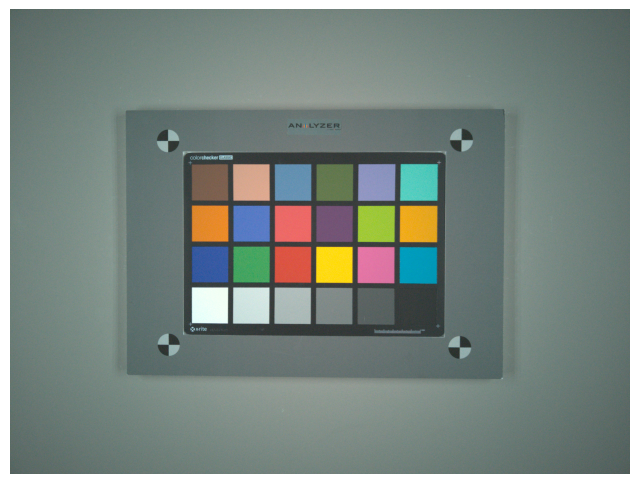

In [36]:
imshow(ims_isp) #retreived image from last week's pipline

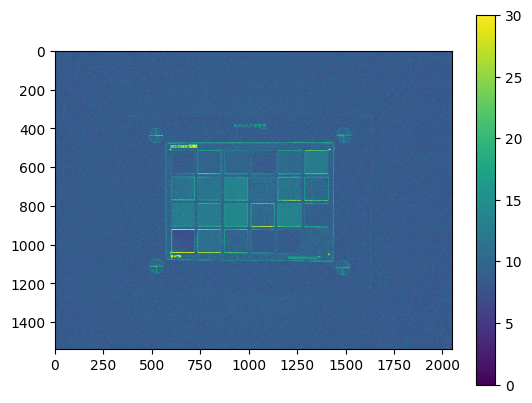

In [37]:
deltalab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(ims_isp)) - colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_rgb))
deltae = np.linalg.norm(deltalab, axis=-1)
plt.imshow(deltae, vmin=0, vmax=30)
plt.colorbar()
plt.show()

Is the difference between the calibrated image and the isp image perceptually lower than the difference between the calibrated image and the camera image?

In [38]:
deltae_isp = np.linalg.norm(lab_isp - lab_rgb, axis=-1)

print(deltae_isp)
print(deltae_rgb)

[  5.02012032   7.45150167   7.78085074   5.22713812   8.50319904
  11.10917406   9.18631002  10.00753394  12.13893399   8.22676825
  10.13646023   7.95033839  11.34364969  10.94007054  12.70364704
   8.89819432  12.2368078    6.82993001   5.95536704   9.28049566
   7.84456419   6.2419333    5.19915339   4.52376861]
[ 11.53478746   3.20889543   6.67561198  10.56731865   8.15732823
   5.83506993  10.50611566   9.1771648    4.02512592   9.23329067
   8.82152624   5.94590168   6.97358328  15.08116162   9.66906652
   8.38707276   3.74166428   8.47525612   2.53364277   1.55976285
   2.68578261   1.21425904   8.36922133  12.64489251]


# Further questions

In this simple example, we took a lot of shortcuts.

* We only ran this example with one illuminant. What happens if you use another illuminant, and why?
* What happens on another device? Will the calibration stay the same? Why, or why not?
* Try to use the calibration on a more realistic image, such as a portrait. What could you improve?
* What color is rendered best, and what color is rendered worst? How could you improve the calibration protocol we used here?
* The camera-generated JPEG can be very different. What additional calibrations do you think they included, and what would their effect be on the color calibration we performed here?

<font color='red'> Answer here</font>
<ul >
<li><font color='red'>If we use another illuminant the calibration matrix will not be the same because the refence rgb values are not the same and so the result will be different (darker or brighter)</font></li>
<li><font color='red'> On another device the calibration is not the same because not all monitors/screens display colors the same way</font></li>
</ul>

## <font color='red'> Use calibration on portait</font>

Remark: I could not read the portrait image stores in the portrait folder in OppoFindX3Pro, it was too voluminous

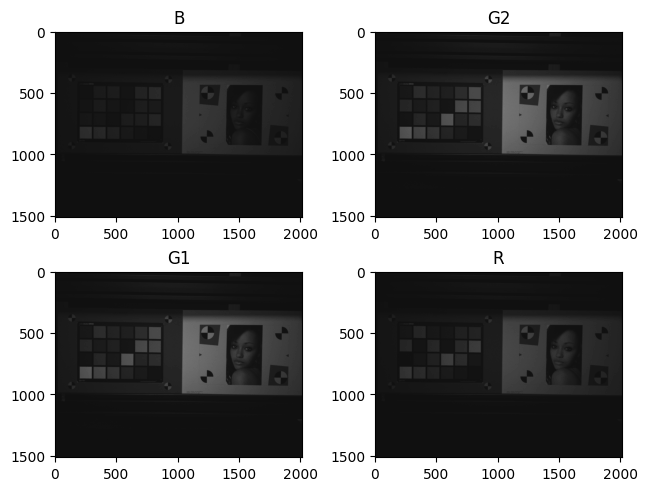

In [39]:
#import raw portait image
raw_portait= rawpy.imread(rf"./Pixel3a/ISO300.dng")

imgB= raw_portait.raw_image[::2, ::2]
imgG2= raw_portait.raw_image[::2, 1::2]
imgR = raw_portait.raw_image[1::2, 1::2]
imgG1 = raw_portait.raw_image[1::2, ::2]

#display raw portrait image channels

fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
axes[0, 0].imshow(imgB, vmin=0, vmax=1024, cmap="gray")
axes[0, 0].set_title("B")
axes[0, 1].imshow(imgG2, vmin=0, vmax=1024, cmap="gray")
axes[0, 1].set_title("G2")
axes[1, 1].imshow(imgR, vmin=0, vmax=1024, cmap="gray")
axes[1, 1].set_title("R")
axes[1, 0].imshow(imgG1, vmin=0, vmax=1024, cmap="gray")
axes[1, 0].set_title("G1")
fig.show()


#calculate its calibraion matrix

# display the calibrated portrait

# compare with jpg format

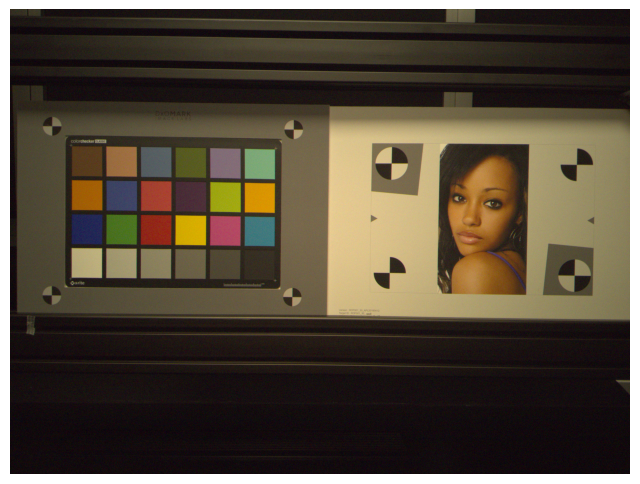

In [40]:
#apply calibration matrix
img_raw = np.dstack([imgR, imgG1, imgB]).astype(np.float32) - raw_portait.black_level_per_channel[0]#rebuild the 3 channels
img_rgb = np.clip(colour.XYZ_to_sRGB((x @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1) #apply calibration here vectorize image row then reshape it again
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
cv2.imwrite("img_rgb.jpg",img_bgr)

imshow(img_rgb)
plt.show()

Text(0.5, 1.0, 'rgb calibrated image')

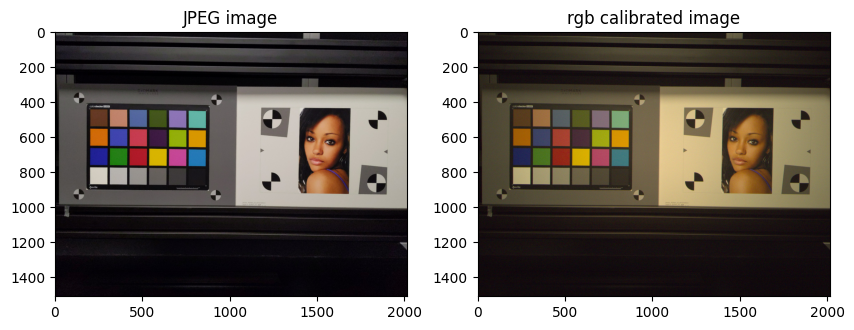

In [41]:
# read the jpg picture

path =r"./Pixel3a/ISO300.jpg"
img_jpg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[::2, ::2, :]

fig, axes= plt.subplots(1,2, figsize= (10, 8))
axes[0].imshow(img_jpg)
axes[0].set_title("JPEG image")

axes[1].imshow(img_rgb)
axes[1].set_title("rgb calibrated image")


<font color='red'> <ul> <li > we see that same as for the color checker the colors are not that accurate on the portrait as well, we see that the brown colors are best rendered,while the white in my impression is the worst. </li>
<li> indeed the jpeg image is better, they may have included, white balance before the color rendering, some edge enhancement step and saturation </li> </ul> </font>
